In [4]:
# Import required libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb



# Read from all data files and create a dataframe for each
features = pd.read_csv('./features.csv/features.csv')
sample_submission = pd.read_csv('./sampleSubmission.csv/sampleSubmission.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('./test.csv/test.csv')
train = pd.read_csv('./train.csv/train.csv')




1. Data Exploration:
 -We explore the data provided to understand better how the data look like.

In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
# Check if there is any null value in the stores dataframe
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [7]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [9]:
# Check if there is any null value in the train dataframe
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [10]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [11]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [13]:
# Check if there is any null value in the features dataframe
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

Based on that, we have more than 50% of the MarkDown datapoints missing. CPI and Unemployment datapoints are also missing, but they are relatively few compared to the total datapoints.

2. Data Preparation
We will do the following: 1) extract year, month and week from Date and add them as new columns, to allow easier access to the Date component during the analysis,

2) convert Date to date type (instead of object) for convinience during analysis later,

3) similarly, convert numerical values (train.isHoliday, test.isHoliday, stores.storeType) to integer values,

4) merge the stores and features df with the train and test df using the Stores and Date column. This will allow easier access to the additional information of the training and test dataset,

5) remove all markdown columns, as there are a lot of data missing. This is because the number of missing data is relatively big to the total dataset size and removing them is a recommended approach to handle missing data and have a complete dataset for analysis,

6) remove from the training and test dataset, columns that are not needed anymore, and rename some columns for clarity,

7) finally, we fill missing values with 0 to prevent issues during analysis.

In [14]:
# Extract month, year and week from the Date column and create 2 new columns
train['Month'] = pd.to_datetime(train['Date']).dt.month
train['Year'] = pd.to_datetime(train['Date']).dt.year
train['Week'] = pd.to_datetime(train['Date']).dt.week

test['Month'] = pd.to_datetime(test['Date']).dt.month
test['Year'] = pd.to_datetime(test['Date']).dt.year
test['Week'] = pd.to_datetime(test['Date']).dt.week

features['Month'] = pd.to_datetime(features['Date']).dt.month
features['Year'] = pd.to_datetime(features['Date']).dt.year
features['Week'] = pd.to_datetime(features['Date']).dt.week

C:\Users\Legion\AppData\Local\Temp\ipykernel_15124\2898957866.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['Week'] = pd.to_datetime(train['Date']).dt.week
C:\Users\Legion\AppData\Local\Temp\ipykernel_15124\2898957866.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['Week'] = pd.to_datetime(test['Date']).dt.week
C:\Users\Legion\AppData\Local\Temp\ipykernel_15124\2898957866.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  features['Week'] = pd.to_datetime(features['Date']).dt.week


In [15]:
# Convert the 'Date' column to datetime format
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

In [16]:
# Convert numerical values to integers
features['IsHoliday'] = features['IsHoliday'].astype(int)

train['IsHoliday'] = train['IsHoliday'].astype(int)
test['IsHoliday'] = test['IsHoliday'].astype(int)

In [17]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Month,Year,Week
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,2,2010,5
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,2,2010,6
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0,2,2010,7
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0,2,2010,8
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0,3,2010,9


In [18]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year,Week
0,1,1,2010-02-05,24924.50,0,2,2010,5
1,1,1,2010-02-12,46039.49,1,2,2010,6
2,1,1,2010-02-19,41595.55,0,2,2010,7
3,1,1,2010-02-26,19403.54,0,2,2010,8
4,1,1,2010-03-05,21827.90,0,3,2010,9


In [19]:
# Find how many different types of stores there are
stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [20]:
# Find how many different types of stores there are number
stores['Type'].nunique()

3

In [21]:
# Map the different types of stores to integer values and assign them to the Type column
value_to_int = {'A': 1, 'B': 2, 'C': 3}
stores['Type'] = stores['Type'].map(value_to_int)

In [22]:
# Merge additional features to the train and test datasets
train = train.merge(stores, on='Store', how='left')
train = train.merge(features, on=['Store', 'Date'], how='left')

test = test.merge(stores, on='Store', how='left')
test = test.merge(features, on=['Store', 'Date'], how='left')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Month_x,Year_x,Week_x,Type,Size,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month_y,Year_y,Week_y
0,1,1,2010-02-05,24924.50,0,2,2010,5,1,151315,...,NaN,NaN,NaN,NaN,211.096358,8.106,0,2,2010,5
1,1,1,2010-02-12,46039.49,1,2,2010,6,1,151315,...,NaN,NaN,NaN,NaN,211.242170,8.106,1,2,2010,6
2,1,1,2010-02-19,41595.55,0,2,2010,7,1,151315,...,NaN,NaN,NaN,NaN,211.289143,8.106,0,2,2010,7
3,1,1,2010-02-26,19403.54,0,2,2010,8,1,151315,...,NaN,NaN,NaN,NaN,211.319643,8.106,0,2,2010,8
4,1,1,2010-03-05,21827.90,0,3,2010,9,1,151315,...,NaN,NaN,NaN,NaN,211.350143,8.106,0,3,2010,9


In [23]:
# Drop duplicate and unnecessary columns
columns_to_drop = ['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5','IsHoliday_y','Month_y','Year_y','Week_y']
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)

In [24]:
# Rename some columns
new_column_names = {
    'IsHoliday_x': 'IsHoliday',
    'Month_x': 'Month',
    'Year_x' : 'Year',
    'Week_x' : 'Week'
}

train = train.rename(columns=new_column_names)
test = test.rename(columns=new_column_names)

In [25]:
# Fill missing values
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [26]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year,Week,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,2,2010,5,1,151315,42.31,2.572,211.096358,8.106
1,1,1,2010-02-12,46039.49,1,2,2010,6,1,151315,38.51,2.548,211.242170,8.106
2,1,1,2010-02-19,41595.55,0,2,2010,7,1,151315,39.93,2.514,211.289143,8.106
3,1,1,2010-02-26,19403.54,0,2,2010,8,1,151315,46.63,2.561,211.319643,8.106
4,1,1,2010-03-05,21827.90,0,3,2010,9,1,151315,46.50,2.625,211.350143,8.106


3. Exploratory Data Analysis:
--We are going to do some exploratory data analysis to gather a better understanding on the Walmart stores and sales. First, we find correlations between the attributes.

In [27]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Month', 'Year',
       'Week', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

<Figure size 900x700 with 0 Axes>

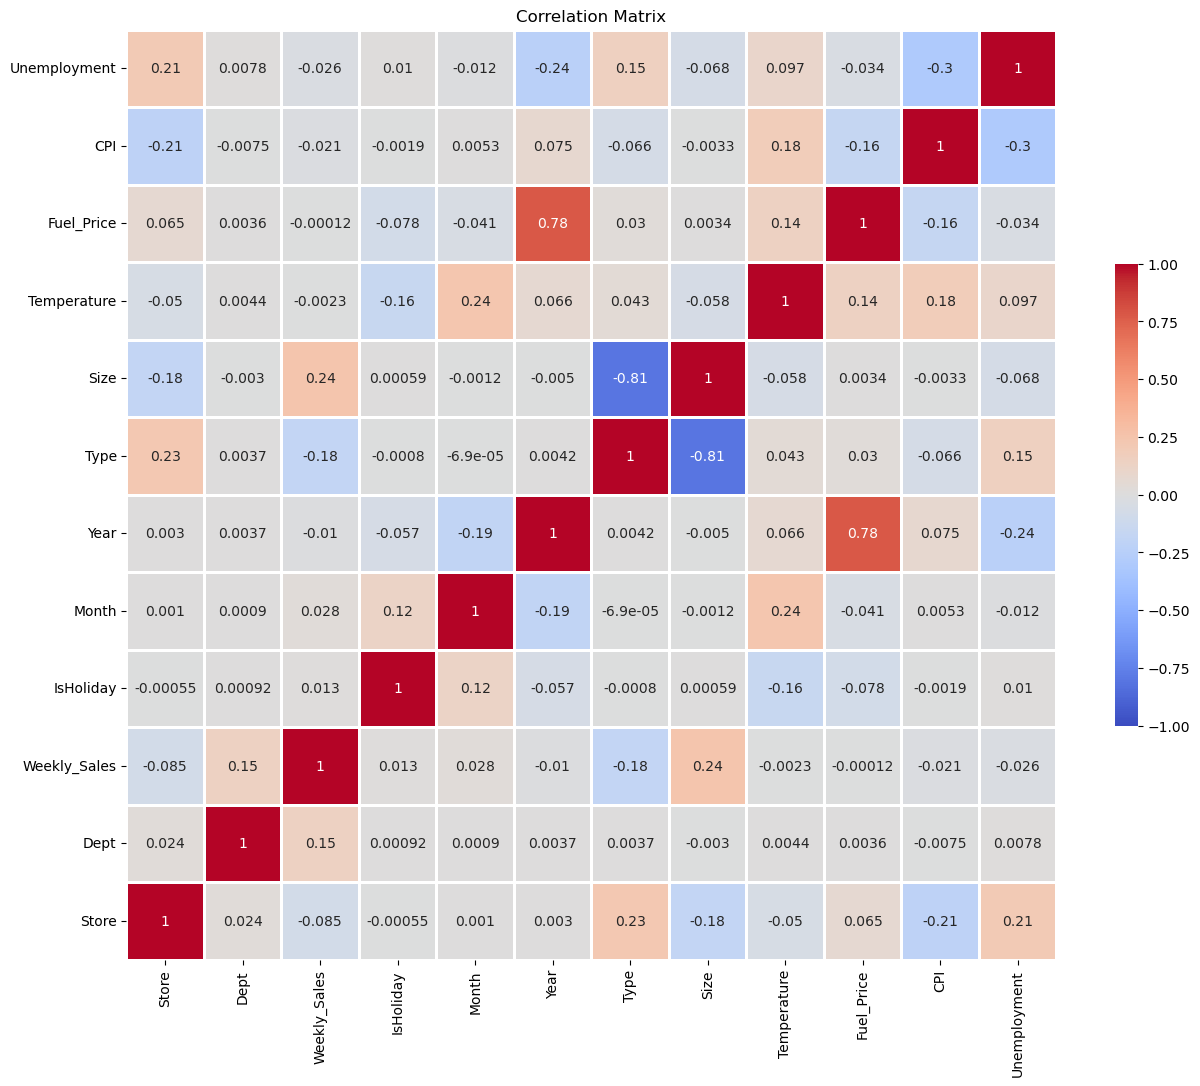

In [28]:
correlation = train[['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Month', 'Year',
       'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

# Correlation matrix
palette = sns.color_palette("muted", 3)
plt.figure(figsize=(9,7))

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation , annot=True, cmap="coolwarm",linewidths=2,vmax=1, vmin=-1, square=True,
                 cbar_kws={"shrink": 0.4}).invert_yaxis()
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows that weekly sales are mostly influenced by department and size of the store. Hence, we look into individual features to gather more insights.

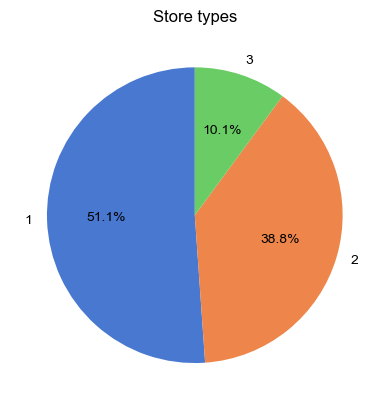

In [29]:
# Pie chart of store types
palette = sns.color_palette("muted", 3)
fig, ax = plt.subplots()

types=train['Type'].value_counts(dropna=False)
ax.pie(types, labels=types.index, autopct='%1.1f%%', shadow=False, startangle=90, colors=palette)
ax.set_title("Store types", fontsize=12)
sns.set()
plt.show()

The above pie chart shows that most of the stores are of type 1 (or 'A'), and stores of type 3 (or 'C') are the least to be found.

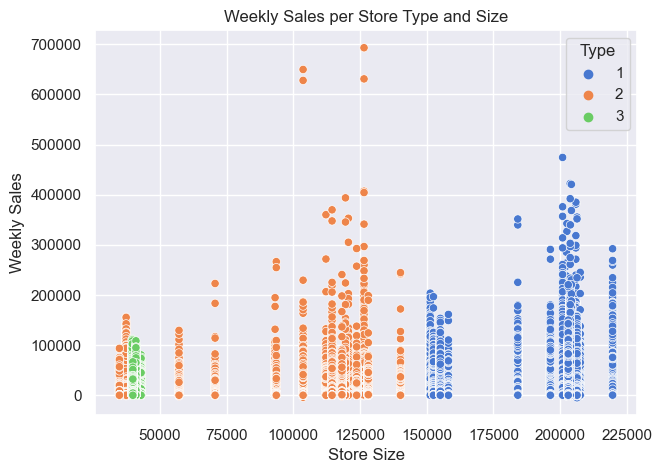

In [30]:
# Scatter plot of weekly sales by store type and size
plt.figure(figsize=(7,5))
p = sns.scatterplot(data=train,x='Size',y='Weekly_Sales',hue='Type', palette=palette)

p.set_title("Weekly Sales per Store Type and Size", fontsize=12)
p.set_xlabel("Store Size")
p.set_ylabel("Weekly Sales")

sns.set_context("paper")
sns.set_style("white")

plt.show()

The above scatterplot shows that as the store size increases the sales increase too. Also, there are mainly 3 clusters where the size of the store depends on the type of it. In other words, stores of type 1 are usually the biggest in size, while stores of type 3 are usually the smallest. Stores of type 2 are of medium size.


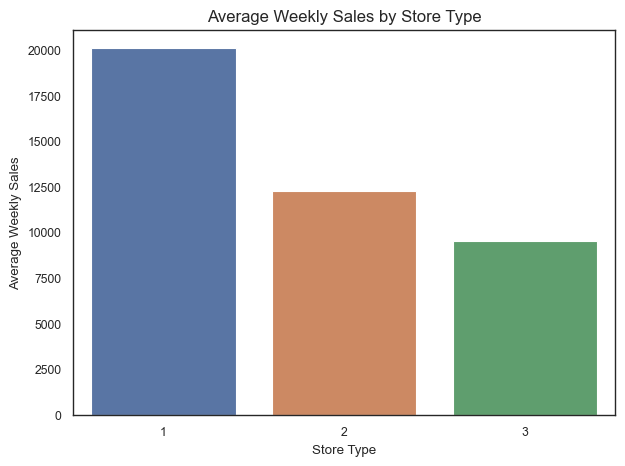

In [31]:
# Bar plot of weekly sales by store type
avg_sales = train.groupby('Type')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(7,5))
p = sns.barplot(x='Type', y='Weekly_Sales', data=avg_sales)

p.set_title('Average Weekly Sales by Store Type', fontsize=12)
p.set_xlabel('Store Type')
p.set_ylabel('Average Weekly Sales')

sns.set_context("paper")
sns.set_style("white")

plt.show()

Stores of type 1 are the most successful in sales.

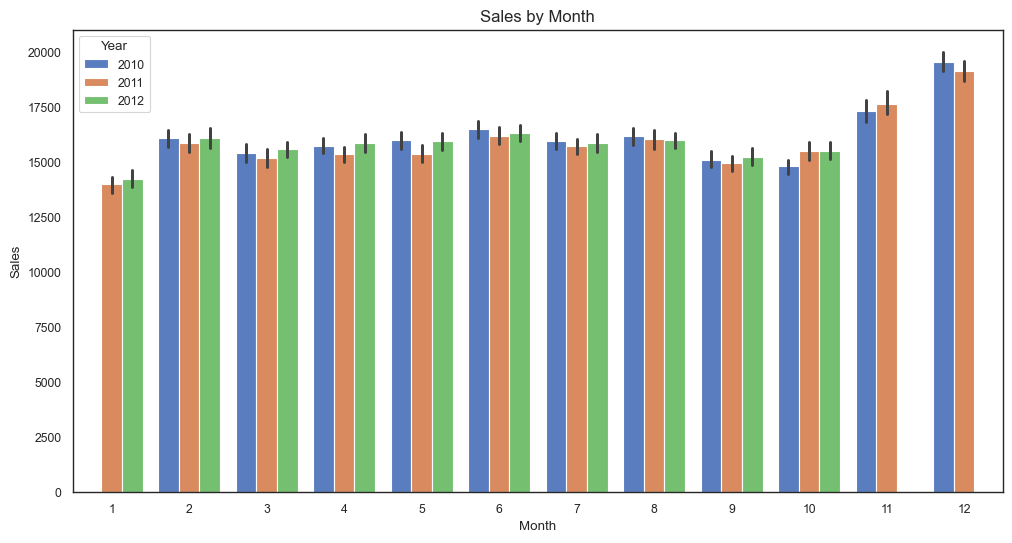

In [32]:
# Bar plot of sales over 3 years by month 
plt.figure(figsize=(12, 6))
p = sns.barplot(data=train,x='Month',y='Weekly_Sales',hue='Year',palette=palette)
plt.ylabel('Sales')

p.set_title('Sales by Month', fontsize=12)
p.set_xlabel('Month')
p.set_ylabel('Sales')

sns.set_context("paper")
sns.set_style("white")
plt.legend(loc='upper left', title='Year')

plt.show()

The above bar plot indicates that sales are similar between the years. Only 2011 sales are slightly lower than 2010 and 2012. In addition, sales are much higher in November and December, when it is the holiday season. In contrast, the lowest sales occur in January, when the holiday season is over.

In [33]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Month', 'Year',
       'Week', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

In the following we will look whether any of the features influences sales.


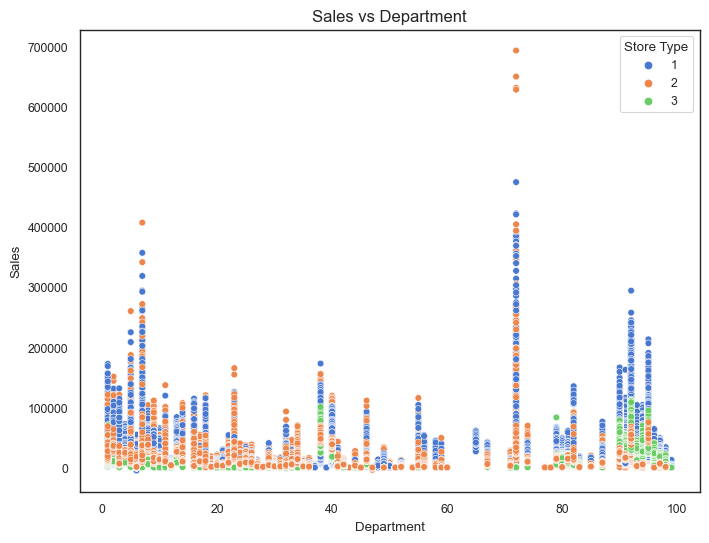

In [34]:
# Scatter plot of sales vs department 
plt.figure(figsize=(8, 6))
p = sns.scatterplot(data=train,
                y='Weekly_Sales',
                x='Dept',hue='Type',
                palette=palette)

plt.ylabel('Sales')

p.set_title('Sales vs Department', fontsize=12)
p.set_xlabel('Department')
p.set_ylabel('Sales')

sns.set_context("paper")
sns.set_style("white")
plt.legend(loc='upper right', title='Store Type')

plt.show()

The above scatter plot shows that sales vary across departments and depend on them, as some departments have much higher sales than others.

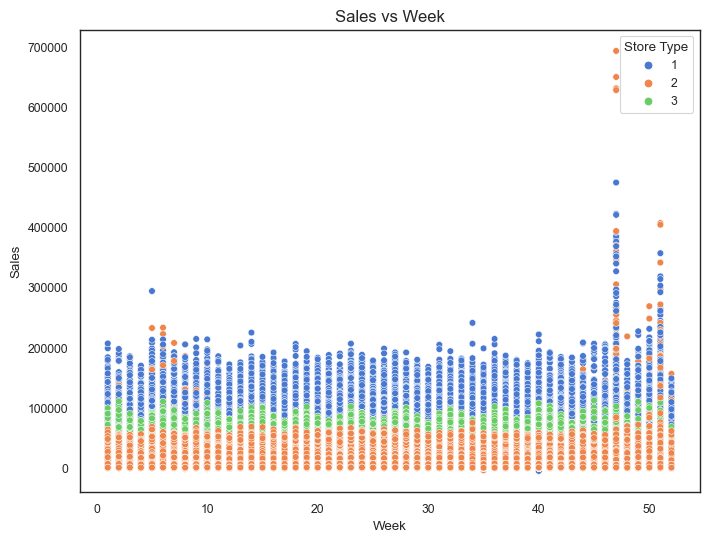

In [35]:
# Scatter plot of sales vs week
palette = sns.color_palette("muted", 3)
plt.figure(figsize=(8, 6))
p = sns.scatterplot(data=train,
                y='Weekly_Sales',
                x='Week',hue='Type',
                palette=palette)

p.set_title('Sales vs Week', fontsize=12)
p.set_xlabel('Week')
p.set_ylabel('Sales')

sns.set_context("paper")
sns.set_style("white")
plt.legend(loc='upper right', title='Store Type')

plt.show()

The scatter plot shows that sales remain the same across all weeks, with the exception of the last weeks of the year, where there are holidays.

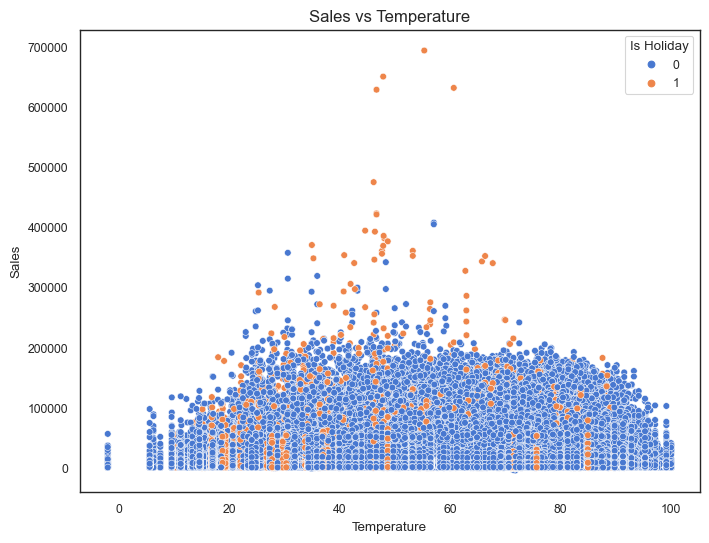

In [36]:
# Scatter plot of sales vs temperature
palette = sns.color_palette("muted", 2)
plt.figure(figsize=(8, 6))
p = sns.scatterplot(data=train,
                y='Weekly_Sales',
                x='Temperature',hue='IsHoliday',
                palette=palette)

p.set_title('Sales vs Temperature', fontsize=12)
p.set_xlabel('Temperature')
p.set_ylabel('Sales')

sns.set_context("paper")
sns.set_style("white")
plt.legend(loc='upper right', title='Is Holiday')

plt.show()

The above scatterplot shows that in general temperature does not affect sales, except for very low and very high temperatures, where sales are naturally lower.



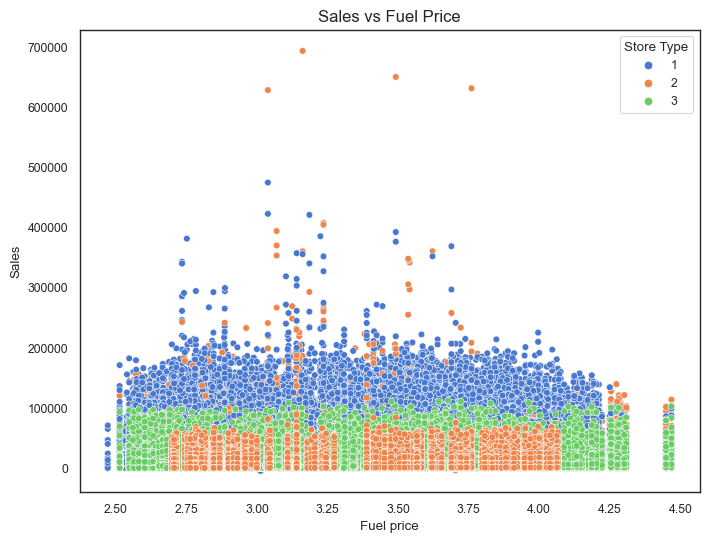

In [37]:
# Scatter plot of sales vs fuel prices
palette = sns.color_palette("muted", 3)
plt.figure(figsize=(8, 6))
p = sns.scatterplot(data=train,
                y='Weekly_Sales',
                x='Fuel_Price',hue='Type',
                palette=palette)

p.set_title('Sales vs Fuel Price', fontsize=12)
p.set_xlabel('Fuel price')
p.set_ylabel('Sales')

sns.set_context("paper")
sns.set_style("white")
plt.legend(loc='upper right', title='Store Type')

plt.show()


The above scatterplot shows that fuel prices do not influence sales, as sales remain at thee same level, indepent of the increase of the fuel price.

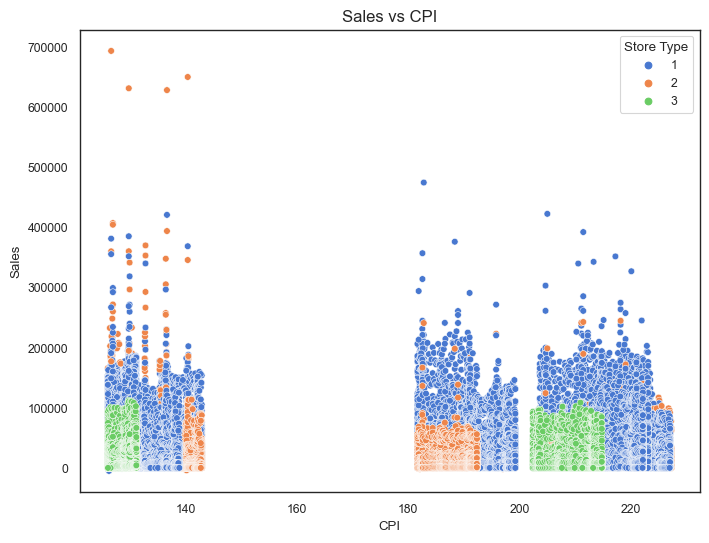

In [38]:
# Scatter plot of sales vs CPI prices
palette = sns.color_palette("muted", 3)
plt.figure(figsize=(8, 6))
p = sns.scatterplot(data=train,
                y='Weekly_Sales',
                x='CPI',hue='Type',
                palette=palette)

p.set_title('Sales vs CPI', fontsize=12)
p.set_xlabel('CPI')
p.set_ylabel('Sales')

sns.set_context("paper")
sns.set_style("white")
plt.legend(loc='upper right', title='Store Type')

plt.show()

The above scatterplot shows that sales remain at the same levels, independent of the increase of CPI.

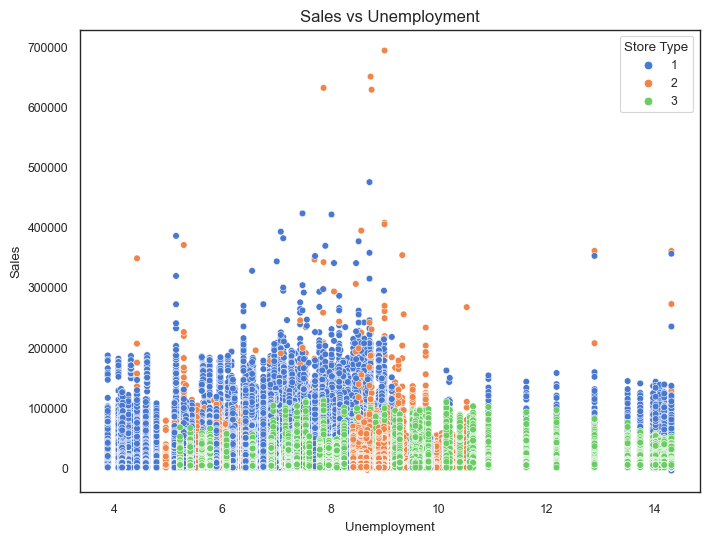

In [39]:
# Scatter plot of sales vs Unemployment
palette = sns.color_palette("muted", 3)
plt.figure(figsize=(8, 6))
p = sns.scatterplot(data=train,
                y='Weekly_Sales',
                x='Unemployment',hue='Type',
                palette=palette)

p.set_title('Sales vs Unemployment', fontsize=12)
p.set_xlabel('Unemployment')
p.set_ylabel('Sales')

sns.set_context("paper")
sns.set_style("white")
plt.legend(loc='upper right', title='Store Type')

plt.show()

The above scatterplot shows that sales are in general independent of the unemployment rate, except for very high unemployment rates where sales decrease slightly.

3. Model training:**
As we found, some of the features do not influence sales, so we will remove them and keep only the important ones ['Store', 'Size', 'Dept', 'Month','Type', 'Year','Week','IsHoliday'].

In [40]:
# Preprocessing data for training

Y_train = train['Weekly_Sales']

X_train = train[['Store', 'Size', 'Dept', 'Month','Type', 'Year','Week','IsHoliday']]
X_test = train[['Store', 'Size', 'Dept', 'Month','Type', 'Year','Week','IsHoliday']]

In [41]:
# Method to compute the WMAE
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [42]:
# Calculating mean_squared_error
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

Baseline model
We compute a baseline model to compare the WMAE of it with other ML models.

In [43]:
Mean = np.mean(Y_train)
predicted_value  = np.full((train.shape[0]), Mean)
print("Model Performance(WMAE) of Mean Model: ",WMAE(train,Y_train, predicted_value))

Model Performance(WMAE) of Mean Model:  15333.25


In [44]:
Median = np.median(Y_train)
predicted_value  = np.full((train.shape[0]), Median)
print("Model Performance(WMAE) of Median Model: ",WMAE(train,Y_train, predicted_value))

Model Performance(WMAE) of Median Model:  13606.16


In [45]:
# Splitting and training
train_inputs, val_inputs, train_targets, val_targets = train_test_split(X_train, Y_train, test_size=0.2)

In [46]:
model_list = {'linear regression':SGDRegressor(),
              'SVR':SGDRegressor(loss = 'epsilon_insensitive'), 
              'ElasticNet':ElasticNet(), 'RandomForest':RandomForestRegressor(),
              'XGboost':lgb.LGBMRegressor()}

for  model_name,model in model_list.items():
     model.fit(train_inputs,train_targets)
     predicted = model.predict(val_inputs)
     print('WMAE score of ',model_name,' : ',WMAE(val_inputs,val_targets,predicted))
     print(100*'-')

c:\Users\Legion\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


WMAE score of  linear regression  :  3.315116731463474e+17
----------------------------------------------------------------------------------------------------


c:\Users\Legion\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


WMAE score of  SVR  :  445422.14
----------------------------------------------------------------------------------------------------
WMAE score of  ElasticNet  :  14697.07
----------------------------------------------------------------------------------------------------
WMAE score of  RandomForest  :  1484.75
----------------------------------------------------------------------------------------------------


c:\Users\Legion\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Legion\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 8
[LightGBM] [Info] Start training from score 15986.113884
WMAE score of  XGboost  :  4198.68
----------------------------------------------------------------------------------------------------


Based on the results, RandomForest and XGboost have the best (lowest) WMAE score. Following, we will hypertune the RandomForest model.

RandomForest model

In [47]:
n_estimators = [100,120,140]
max_depth = [25, 27, 30]

for n_estimator in n_estimators:
    for depth in max_depth:
        rf_model = RandomForestRegressor(n_estimators=n_estimator, max_depth=depth)
        
        rf_model.fit(train_inputs, train_targets)
        
        y_pred = rf_model.predict(val_inputs)
        
        print('WMAE for RandomForest:',WMAE(val_inputs,val_targets,y_pred), 'n_estimators:', n_estimator, ', max_depth:' , depth)
        print(100*'-')

WMAE for RandomForest: 1481.98 n_estimators: 100 , max_depth: 25
----------------------------------------------------------------------------------------------------
WMAE for RandomForest: 1480.08 n_estimators: 100 , max_depth: 27
----------------------------------------------------------------------------------------------------
WMAE for RandomForest: 1481.38 n_estimators: 100 , max_depth: 30
----------------------------------------------------------------------------------------------------
WMAE for RandomForest: 1481.57 n_estimators: 120 , max_depth: 25
----------------------------------------------------------------------------------------------------
WMAE for RandomForest: 1479.42 n_estimators: 120 , max_depth: 27
----------------------------------------------------------------------------------------------------
WMAE for RandomForest: 1483.76 n_estimators: 120 , max_depth: 30
----------------------------------------------------------------------------------------------------
WMAE

Best parameters for the RandomForest model are n_estimators = 140, max_depth = 27.

In [48]:
RFR_model = RandomForestRegressor(n_estimators= 140 , max_depth= 27)
RFR_model.fit(train_inputs,train_targets)

RandomForestRegressor(max_depth=27, n_estimators=140)

In [49]:
# Compute accuracy of training data
RFR_model.score(train_inputs,train_targets)

0.9969527476222592

In [50]:
# Compute accuracy of validation data
RFR_model.score(val_inputs, val_targets)

0.9815183647945633

In [51]:
# Make and evaluate predictions
RFR_x_pred = RFR_model.predict(train_inputs)
RFR_x_pred

array([ 9227.73632143, 11327.750575  , 10843.03871429, ...,
       56490.984     ,   708.97048773,  3594.84692857])

In [52]:
# Evaluation
rmse(RFR_x_pred,train_targets)

1253.8352913307122

In [53]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': RFR_model.feature_importances_
}).sort_values('importance', ascending=False)

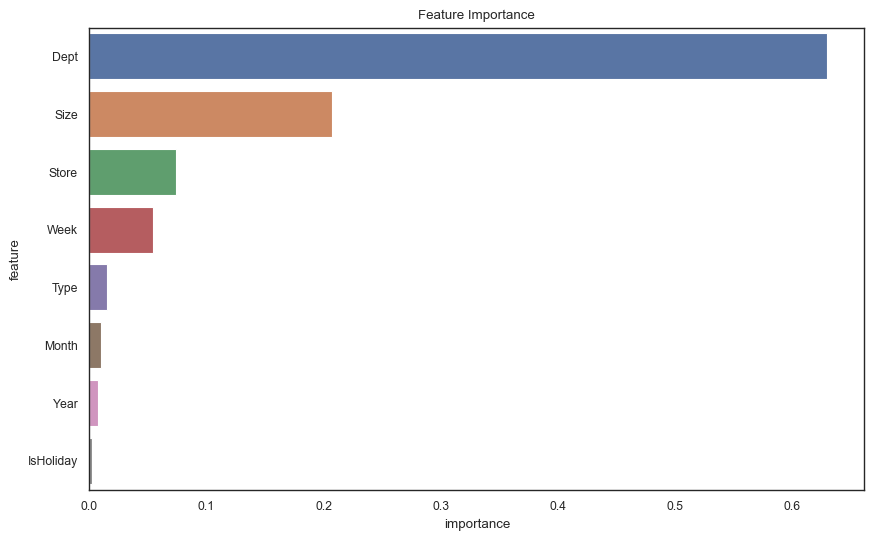

In [54]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

The bar plot shows that the most important feature is the Department, and the Size.



In [55]:
# Making predictions
RFR_x_preds = RFR_model.predict(X_test)
RFR_x_preds

array([24266.90335714, 43222.32428571, 41979.95228571, ...,
         901.81414286,   853.438     ,   968.83157143])

4. Save predictions to .csv
As we can see, the RandomForest model has a lower WMAE score so we choose this to make predictions for the weekly sales and save them into a .csv file.

In [56]:
# Making predictions
Final = X_test[['Store', 'Dept', 'Week']]

test['Weekly_Sales'] = pd.DataFrame({'Weekly_Sales': RFR_x_preds})
test['Weekly_Sales'] = test['Weekly_Sales'].round(2)

In [57]:
test.head()

,Store,Dept,Date,IsHoliday,Month,Year,Week,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,1,2012-11-02,0,11,2012,44,1,151315,55.32,3.386,223.462779,6.573,24266.90
1,1,1,2012-11-09,0,11,2012,45,1,151315,61.24,3.314,223.481307,6.573,43222.32
2,1,1,2012-11-16,0,11,2012,46,1,151315,52.92,3.252,223.512911,6.573,41979.95
3,1,1,2012-11-23,1,11,2012,47,1,151315,56.23,3.211,223.561947,6.573,20001.04
4,1,1,2012-11-30,0,11,2012,48,1,151315,52.34,3.207,223.610984,6.573,21397.94


In [58]:
sample_submission['Weekly_Sales'] = test['Weekly_Sales']
sample_submission.to_csv('submission.csv',index=False)

In [59]:
preds1 = pd.read_csv('submission.csv')
preds1

,Id,Weekly_Sales
0,1_1_2012-11-02,24266.90
1,1_1_2012-11-09,43222.32
2,1_1_2012-11-16,41979.95
3,1_1_2012-11-23,20001.04
4,1_1_2012-11-30,21397.94
...,...,...
115059,45_98_2013-06-28,5772.17
115060,45_98_2013-07-05,6619.20
115061,45_98_2013-07-12,7150.58
115062,45_98_2013-07-19,7374.65
